# Fine-tuning SAM on Satellite Images for Street Segmentation



In [24]:
import torch
import numpy as np
import random

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


## Loading the dataset

In [25]:
# written by Jannek Ulm 16.5.2024
# code was inspired by the following sources: https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

from utils.image_loading import * 
from utils.torch_device import *
from custom_datasets import Sat_Mask_Dataset, Sat_Only_Image_Dataset

device = get_torch_device(allow_mps=True)
print("using device:",device)

###########

original_data = {}
original_data["images"] =load_training_images()
original_data["masks"] = load_groundtruth_images()

city_names = ["nyc"]
#city_names = ["boston","nyc","zurich","philadelphia"]
custom_data = {"images":[],"masks":[]} # stores images and gt masks

for name in city_names:
    custom_data["images"].extend(load_training_images(name))
    custom_data["masks"].extend(load_groundtruth_images(name))

custom_data["images"] = custom_data["images"]#[0:200]
custom_data["masks"] = custom_data["masks"]#[0:200]

assert (len(custom_data["images"]) == len(custom_data["masks"]))


print("the raw custom dataset contains",len(custom_data["images"]),"images")

print("custom ds: (min,mean,max) street ratio",get_street_ratio_mmm(custom_data["masks"]))
#print("orig ds: (min,mean,max) street ratio",get_street_ratio_mmm(original_data["masks"]))
#print("custom ds with ignore under threshold: (min,mean,max) street ratio",get_street_ratio_mmm(custom_data["masks"],min_ratio_threshold=0.03))
# create a dataset
custom_data_set = Sat_Mask_Dataset(custom_data["images"], custom_data["masks"],min_street_ratio=0.03,max_street_ratio=1.0, do_random=False)
#original_data_set = Sat_Mask_Dataset(original_data["images"],original_data["masks"])
print("after cleanup, the dataset now contains",len(custom_data_set),"images")


# submission kaggle dataset

kaggle_submission_images = load_test_images()
submission_data_set = Sat_Only_Image_Dataset(kaggle_submission_images)


using device: mps
the raw custom dataset contains 1869 images
custom ds: (min,mean,max) street ratio (0.0, 0.16189137907972165, 0.5875875)
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.052434456928838954  num discarded: 98
after cleanup, the dataset now contains 1771 images


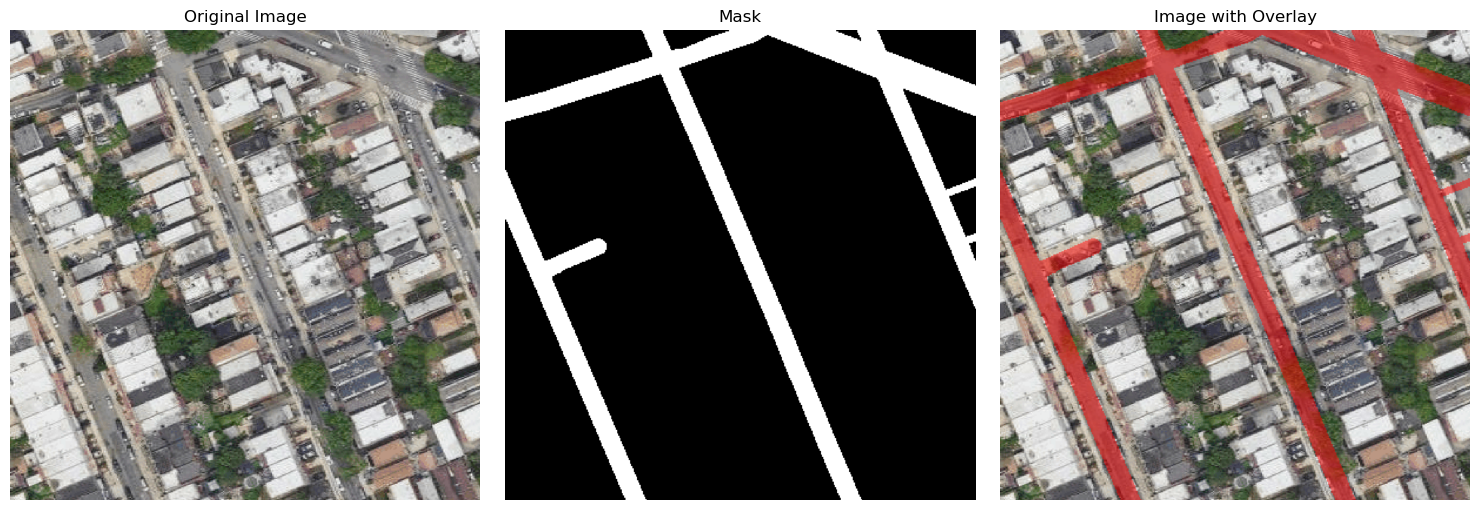

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# get some random training images
idx = 4
image, mask = custom_data_set[idx]

img = np.array(image).astype(np.uint8)
# swap first and third dimension
img = np.swapaxes(img, 0, 2)
mask = np.array(mask)
mask = np.swapaxes(mask, 0, 2)

# Create a reddish tone image with the same shape as the original image
reddish_tone = np.zeros_like(img)
reddish_tone[..., 0] = 255  # Red channel to maximum

# Define the opacity for the overlay
opacity = 0.5

# Ensure the mask is binary (0 or 255) and has the same shape as the original image
binary_mask = (mask > 0).astype(np.uint8) * 255

# Blend the original image and the reddish tone based on the mask
blended_image = np.where(binary_mask == 255, 
                         (img * (1 - opacity) + reddish_tone * opacity).astype(np.uint8),
                         img)

# Display the original image, mask, and blended image side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')

axes[2].imshow(blended_image)
axes[2].set_title('Image with Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Dataloader

In [27]:
train_split = 0.8


gpu_batch_size = 1

import torch.utils.data
custom_train_dataset, custom_test_dataset = torch.utils.data.random_split(custom_data_set, [train_split, 1-train_split])
#original_train_dataset, original_test_dataset = torch.utils.data.random_split(original_data_set, [train_split, 1-train_split])


print(len(custom_train_dataset), len(custom_test_dataset))

from torch.utils.data import DataLoader


# CHECK IF THE FOR MULTIPLE NUM WORKERS THE CODE WORKS AS EXPECTED
# SEEMS TO BE CAUSING ISSUES WITH LONG startup and shutdown times for each epoch

# decided to drop last to make f1/loss score mean computation easier.

#original_train_dataloader = DataLoader(original_train_dataset, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
#original_test_dataloader = DataLoader(original_test_dataset, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)
#original_dataloader = DataLoader(original_data_set, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)

# dataloader for submission dataset: 
submission_dataloader = DataLoader(submission_data_set, batch_size=gpu_batch_size, shuffle=False, drop_last=False,num_workers=4,persistent_workers=True)

#custom_train_dataloader = DataLoader(custom_train_dataset, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
#custom_test_dataloader = DataLoader(custom_test_dataset, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)
custom_dataloader = DataLoader(custom_data_set, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)

1417 354


## Loading the model

In [28]:

############ (CUSTOM SAM (stored in repo))
from custom_segment_anything.segment_anything import sam_model_registry
from custom_segment_anything.segment_anything.CUSTOM_SAM import *

# load the model from checkpoints on disk:
def load_sam_decoder_model_from_checkpoint(encoder_option:int, device,decoder,encoder_finetune_num_last_layers=6):
    #
    # encoder_option =0 : for vit_b with the encoder that just retunrs the final block output.
    # encoder_option =1 : for vit_b with the encoder that returns the intermediate outputs + final output.  

    sam_checkpoint_path = "custom_segment_anything/model_checkpoints/"
    # base, large, huge checkpoints. 
    checkpoint_names = ["vit_b","vit_b_intermediate"]#,"vit_l","vit_h"]
    checkpoints = ["sam_vit_b_01ec64.pth"] #,"sam_vit_l_0b3195.pth","sam_vit_h_4b8939.pth"]
    model_paths = [sam_checkpoint_path+checkpoint_name for checkpoint_name in checkpoints]
    sam = sam_model_registry[checkpoint_names[encoder_option]](checkpoint=model_paths[0])
    sam.to(device)
    model = SAM_Encoder_Custom_Decoder(sam.preprocess, sam.image_encoder,decoder=decoder,encoder_finetune_num_last_layers=encoder_finetune_num_last_layers)
    model = model.to(device)
    return model


# load the finetnued model state, if already started training. 
def load_finetuned_model(name,device,decoder,encoder_finetune_num_last_layers=6):
    model = load_sam_decoder_model_from_checkpoint(0,device,decoder,encoder_finetune_num_last_layers)
    finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
    model.load_state_dict(torch.load(finetune_path+name,map_location=torch.device('cpu')))
    model = model.to(device)
    return model

############################



def load_sam_model(decoder_option, device, encoder_finetune_num_last_layers,finetuned_model_name="model.pth",sam_checkpoint_or_finetuned="sam"):
    #   
    #   decoder_options: ["conv", "mlp" , "segformer_mlp"]
    #   encoder_finetune_num_last_layers tells how many layers of sam encoder are finetuned, all decoder layers are tuned. 
    #   sam_checkpoint_or_finetuned checks if the model is loaded from a sam checkpoint or a finetuned model with the same architecture.
    #

    # first construct the model from sam_checkpoint:

    if decoder_option == "conv":
        decoder = Conv_Decoder()
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder.decoder,encoder_finetune_num_last_layers)
   
    elif decoder_option == "mlp":
        decoder = MLP_Decoder()
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder,encoder_finetune_num_last_layers)

    elif decoder_option == "spatial-full":
        decoder = MLP_Decoder_Spatially_Aware(context_option=1)
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder,encoder_finetune_num_last_layers)

    elif decoder_option == "spatial-small":
        decoder = MLP_Decoder_Spatially_Aware(context_option=0)
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder,encoder_finetune_num_last_layers)
    elif decoder_option == "skip-connect":
        decoder = Skip_MLP_Decoder()
        model = load_sam_decoder_model_from_checkpoint(1,device,decoder,encoder_finetune_num_last_layers)
    else:
        raise ValueError("invalid decoder option")
    
    # if should load from fine-tuned model, load the model from the finetuned path.
    if sam_checkpoint_or_finetuned == "finetuned":
        finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
        model.load_state_dict(torch.load(finetune_path+finetuned_model_name+".pth",map_location=torch.device('cpu')))
    elif sam_checkpoint_or_finetuned == "sam":
        pass
        # already initialized model from sam_checkpoint
    else: 
        raise ValueError("invalid sam_checkpoint_or_finetuned option")
    
    
    # Unfreeze last layers of the encoder
    for layer_number, param in enumerate(model.sam_encoder.parameters()):
        if layer_number > 176 - encoder_finetune_num_last_layers:
            param.requires_grad = True
    
    # Unfreeze neck of the encoder
    model.sam_encoder.neck.requires_grad = True
    model.requires_grad = True
    print("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))
    model = model.to(device)
    return model

# Actually loading the model

In [29]:
finetuned_model_name = "model_2_mlp_decoder_finetune_last_85_epoch_2"

model = load_sam_model("mlp",device,encoder_finetune_num_last_layers=0,finetuned_model_name=finetuned_model_name,sam_checkpoint_or_finetuned="finetuned")

print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))

Last layer number: 176
Percentage of trainable parameters:  0.010153446180800859
Model loaded
Trainable parameters 919808
Total parameters 90590720
Percentage of trainable parameters: 
Percentage of trainable parameters:  0.010153446180800859


In [30]:
print(model)

SAM_Encoder_Custom_Decoder(
  (sam_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3):

In [31]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

sam_encoder.pos_embed False
sam_encoder.patch_embed.proj.weight False
sam_encoder.patch_embed.proj.bias False
sam_encoder.blocks.0.norm1.weight False
sam_encoder.blocks.0.norm1.bias False
sam_encoder.blocks.0.attn.rel_pos_h False
sam_encoder.blocks.0.attn.rel_pos_w False
sam_encoder.blocks.0.attn.qkv.weight False
sam_encoder.blocks.0.attn.qkv.bias False
sam_encoder.blocks.0.attn.proj.weight False
sam_encoder.blocks.0.attn.proj.bias False
sam_encoder.blocks.0.norm2.weight False
sam_encoder.blocks.0.norm2.bias False
sam_encoder.blocks.0.mlp.lin1.weight False
sam_encoder.blocks.0.mlp.lin1.bias False
sam_encoder.blocks.0.mlp.lin2.weight False
sam_encoder.blocks.0.mlp.lin2.bias False
sam_encoder.blocks.1.norm1.weight False
sam_encoder.blocks.1.norm1.bias False
sam_encoder.blocks.1.attn.rel_pos_h False
sam_encoder.blocks.1.attn.rel_pos_w False
sam_encoder.blocks.1.attn.qkv.weight False
sam_encoder.blocks.1.attn.qkv.bias False
sam_encoder.blocks.1.attn.proj.weight False
sam_encoder.blocks.1.a

In [32]:
print(model)

SAM_Encoder_Custom_Decoder(
  (sam_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3):

SAM model + Custom Decoder set to EVAL mode
torch.Size([1, 1, 1024, 1024])
Np arr shape:  (1024, 1024, 1) (1024, 1024, 1)


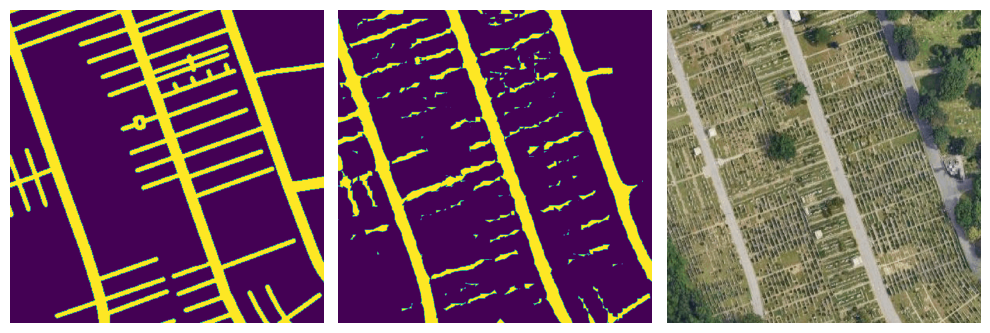

In [33]:
# TAKEN CODE FROM KAGGLE: 


model.eval()
print("SAM model + Custom Decoder set to EVAL mode")

import torch
import torch.nn.functional as F


#sample = original_data_set[10]
sample = custom_data_set[10]
inpt_0, gt_0 = sample[0], sample[1]
with torch.no_grad():
    decoder_opt = torch.sigmoid(model(inpt_0.to(device).unsqueeze(0)))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
gt_0_np = gt_0.to("cpu").numpy().transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape, gt_0_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(gt_0_np)
# Hide the axes of the first subplot
axs[0].axis('off')

# Display img2 on the second subplot
axs[1].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Display img3 on the second subplot
axs[2].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[2].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

# Visulaizing Quality of Predictions

In [34]:
# 3 Samples: 

start_index = 5
samples = []
imgs = []
binary_gts = []
binary_predictions = []

#make and store image, gt, and prediction for 3 samples
for i in range(start_index,start_index+3):
    sample = custom_data_set[i]
    inpt_0, gt_0 = sample[0], sample[1]
    with torch.no_grad():
        decoder_opt = torch.sigmoid(model(inpt_0.to(device).unsqueeze(0)))
    decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
    gt_0_np = gt_0.to("cpu").numpy().transpose(1,2,0)
    temp_img_np = inpt_0.to("cpu").numpy()
    temp_img_np = np.transpose(temp_img_np, [1,2,0])
    temp_img_np = temp_img_np.astype(np.uint8)
    samples.append(sample)
    imgs.append(temp_img_np)

    #make gt and prediction binary
    binary_gts.append((gt_0_np > 0).astype(np.uint8)*255)
    binary_predictions.append((decoder_opt_np > 0).astype(np.uint8)*255)

In [35]:
#create a copy of imgs
imgs_copy = imgs.copy()
binary_gts_copy = binary_gts.copy()
binary_predictions_copy = binary_predictions.copy()

In [36]:

#restore imgs from copy
imgs = imgs_copy.copy()
gts = binary_gts_copy.copy()
predictions = binary_predictions_copy.copy()


In [37]:
#concatenate images horizontally, but remove 12 pixels from left and right from the second image
padding = 31
imgs[1] = imgs[1][:, padding:-padding, :]
gts[1] = gts[1][:, padding:-padding, :]
predictions[1] = predictions[1][:,padding:-padding,:]

# Concatenate images horizontally
image = np.concatenate(imgs, axis=1)
gt = np.concatenate(gts, axis=1)
prediction = np.concatenate(predictions, axis=1)

In [38]:
print("Image shape: ", image.shape)
print("GT shape: ", gt.shape)
print("Prediction shape: ", prediction.shape)

Image shape:  (1024, 3010, 3)
GT shape:  (1024, 3010, 1)
Prediction shape:  (1024, 3010, 1)


# Image

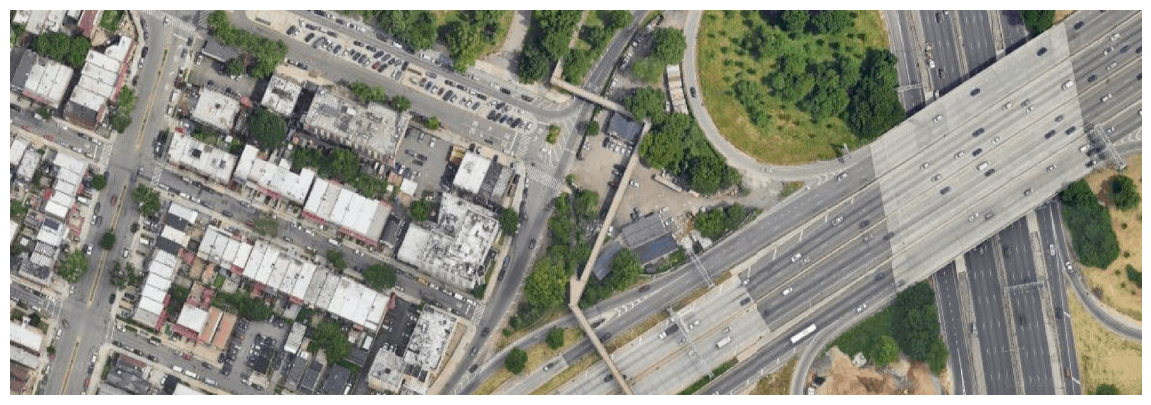

In [39]:
#create a plot of the image 
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(image)
ax.axis('off')
plt.show()

# Prediction

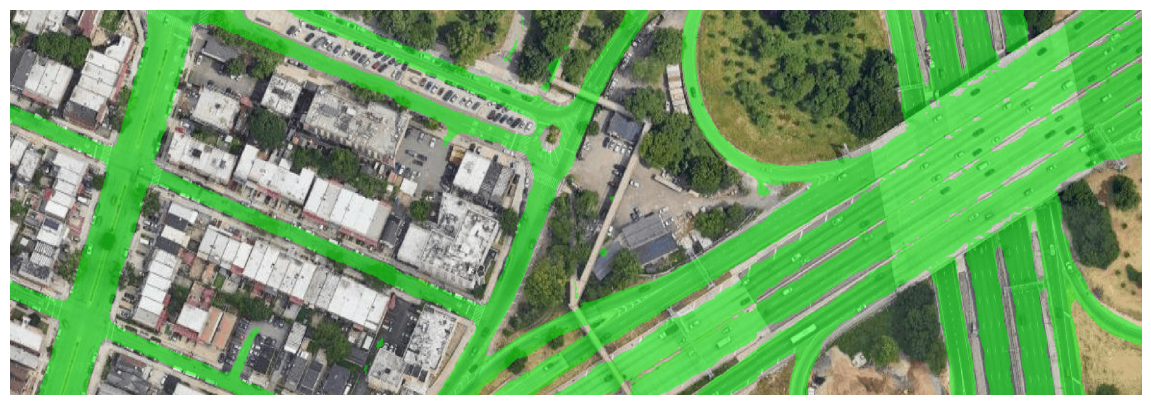

In [40]:
#create a plot of the image with the prediction in greenish 
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Create a reddish tone for missed ground truth
greenish_tone = np.zeros_like(image)
#green channel to max
greenish_tone[..., 1] = 255

blended_image = np.where(prediction == 255, (image * (1 - opacity) + greenish_tone * opacity).astype(np.uint8),
                             image)

ax.imshow(blended_image)
ax.axis('off')
plt.show()

# False Positive, False Negative, True Positive

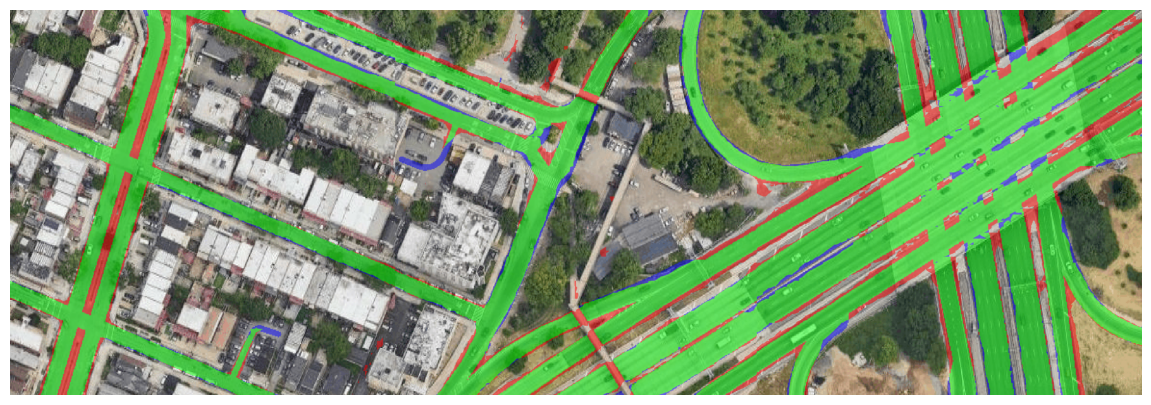

In [41]:
#we have image, gt, and prediction. now lets plot tp green fp blue fn red

#create a plot of the image with the prediction in greenish 
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Create a reddish tone for missed ground truth
# True Positive (TP): prediction and GT both are 1
tp_mask = ((prediction == 255) & (gt == 255)).astype(np.uint8) * 255

# False Positive (FP): prediction is 1, but GT is 0
fp_mask = ((prediction == 255) & (gt == 0)).astype(np.uint8) * 255

# False Negative (FN): GT is 1, but prediction is 0
fn_mask = ((gt == 255) & (prediction == 0)).astype(np.uint8) * 255

# Create color tones for each case
greenish_tone = np.zeros_like(image)
greenish_tone[..., 1] = 255  # Green channel to maximum

blueish_tone = np.zeros_like(image)
blueish_tone[..., 2] = 255  # Blue channel to maximum

reddish_tone = np.zeros_like(image)
reddish_tone[..., 0] = 255  # Red channel to maximum

# Blend the original image with color tones based on the masks
blended_image = np.where(tp_mask == 255, 
                            (image * (1 - opacity) + greenish_tone * opacity).astype(np.uint8),
                            image)

blended_image = np.where(fn_mask == 255, 
                            (image * (1 - opacity) + blueish_tone * opacity).astype(np.uint8),
                            blended_image)

blended_image = np.where(fp_mask == 255, 
                            (image * (1 - opacity) + reddish_tone * opacity).astype(np.uint8),
                            blended_image)


ax.imshow(blended_image)
ax.axis('off')
plt.show()

# with legend

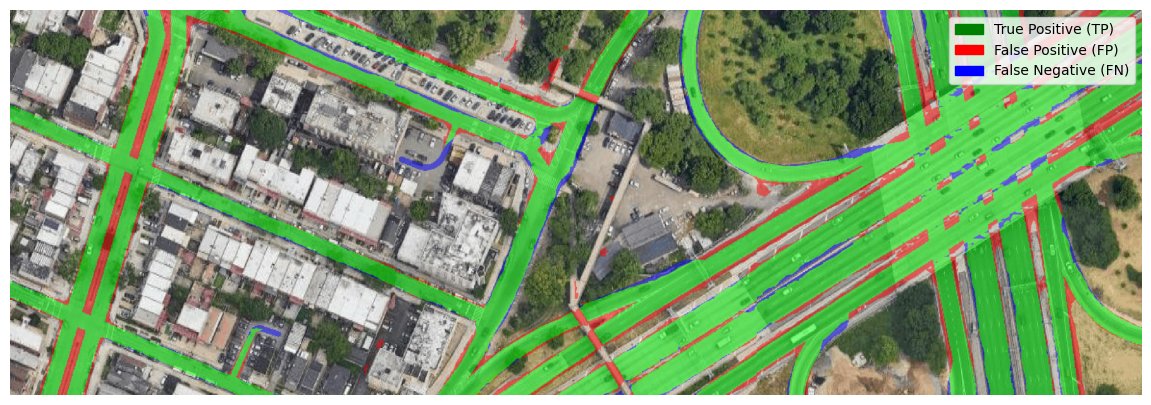

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Assuming image, gt, and prediction are already defined and have the same dimensions
# Create a plot of the image with the prediction in greenish
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Create a reddish tone for missed ground truth
# True Positive (TP): prediction and GT both are 1
tp_mask = ((prediction == 255) & (gt == 255)).astype(np.uint8) * 255

# False Positive (FP): prediction is 1, but GT is 0
fp_mask = ((prediction == 255) & (gt == 0)).astype(np.uint8) * 255

# False Negative (FN): GT is 1, but prediction is 0
fn_mask = ((gt == 255) & (prediction == 0)).astype(np.uint8) * 255

# Create color tones for each case
greenish_tone = np.zeros_like(image)
greenish_tone[..., 1] = 255  # Green channel to maximum

blueish_tone = np.zeros_like(image)
blueish_tone[..., 2] = 255  # Blue channel to maximum

reddish_tone = np.zeros_like(image)
reddish_tone[..., 0] = 255  # Red channel to maximum

# Blend the original image with color tones based on the masks
blended_image = np.where(tp_mask == 255, 
                            (image * (1 - opacity) + greenish_tone * opacity).astype(np.uint8),
                            image)

blended_image = np.where(fn_mask == 255, 
                            (image * (1 - opacity) + blueish_tone * opacity).astype(np.uint8),
                            blended_image)

blended_image = np.where(fp_mask == 255, 
                            (image * (1 - opacity) + reddish_tone * opacity).astype(np.uint8),
                            blended_image)

# Display the image
ax.imshow(blended_image)
ax.axis('off')

# Create custom legend handles
legend_handles = [
    Patch(color='green', label='True Positive (TP)'),
    Patch(color='red', label='False Positive (FP)'),
    Patch(color='blue', label='False Negative (FN)')
]

# Add legend to the plot
ax.legend(handles=legend_handles, loc='upper right')

plt.show()
